<a href="https://colab.research.google.com/github/realBagher/image-segmentation-using-unet/blob/main/model-v1/Image_segmentation_using_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf 
from tensorflow.keras.layers import Dropout,Conv2D,MaxPooling2D,Conv2DTranspose,concatenate
import os 
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
import json as jn 
from PIL import Image, ImageDraw
import cv2 as cv 



In [2]:
!wget https://s3.amazonaws.com/ifashionist-dataset/images/train2020.zip

--2022-09-15 09:06:52--  https://s3.amazonaws.com/ifashionist-dataset/images/train2020.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.198.224
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.198.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3344364592 (3.1G) [application/zip]
Saving to: ‘train2020.zip’

train2020.zip       100%[===================>]   3.11G  33.4MB/s    in 99s     

2022-09-15 09:08:31 (32.3 MB/s) - ‘train2020.zip’ saved [3344364592/3344364592]



In [3]:
!wget https://s3.amazonaws.com/ifashionist-dataset/images/val_test2020.zip


--2022-09-15 09:08:31--  https://s3.amazonaws.com/ifashionist-dataset/images/val_test2020.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.81.70
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.81.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 236499034 (226M) [application/zip]
Saving to: ‘val_test2020.zip’

val_test2020.zip    100%[===================>] 225.54M  32.5MB/s    in 7.5s    

2022-09-15 09:08:39 (30.3 MB/s) - ‘val_test2020.zip’ saved [236499034/236499034]



In [4]:
!wget https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_train2020.json

--2022-09-15 09:08:39--  https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_train2020.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.40.70
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.40.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 542193045 (517M) [application/json]
Saving to: ‘instances_attributes_train2020.json’

instances_attribute 100%[===================>] 517.08M  32.4MB/s    in 16s     

2022-09-15 09:08:56 (32.2 MB/s) - ‘instances_attributes_train2020.json’ saved [542193045/542193045]



In [5]:
!unzip ./train2020.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/52376f1a6cd1f67eddc517b11242960b.jpg  
  inflating: train/236f5f6a3d70aebe9807ee1cdb00a26a.jpg  
  inflating: train/bc3f324781cb94d7632fb449857645d5.jpg  
  inflating: train/febafb43e0a8a5a62bd64d0e1e2c51bb.jpg  
  inflating: train/62f7105882625f0ea9c43639cc450af2.jpg  
  inflating: train/bbaaed6a5643083d11db6c6839ce162c.jpg  
  inflating: train/1127d6d9a4ad34e3f6ea6abfed23fadf.jpg  
  inflating: train/dc8e143844a77f42337c7f6d1a83f0a9.jpg  
  inflating: train/2ab1eb6b641df05b18bbcd31546f41c3.jpg  
  inflating: train/39c5ccb6ae593374c065719c46b14cb7.jpg  
  inflating: train/20c4c3ee365b7b8b9b813176899d8bcc.jpg  
  inflating: train/43929c91575dc1d8a0aebc4f5ac7592d.jpg  
  inflating: train/c3045c901c4c91d7564a3407d351d1b5.jpg  
  inflating: train/fe6bdd2397004cd9be166166626d42ba.jpg  
  inflating: train/fd191f5c7af85e75c8804d2b9c51fb41.jpg  
  inflating: train/26bf90cdaa9a8c53e77fa2dfdd95e8ab.jpg  
  inflating: train/90

In [6]:
!unzip ./val_test2020.zip

Archive:  ./val_test2020.zip
   creating: test/
  inflating: test/968a55c5e4d4d763b0007b1fa8993644.jpg  
  inflating: test/93689df6d05b8406fcf9083057344e3e.jpg  
  inflating: test/63428001d1dead4d5afcbabfc9777c67.jpg  
  inflating: test/90b3a9254b942e4fb986258899b4d39c.jpg  
  inflating: test/2ddb7061e681364714475dc59c928420.jpg  
  inflating: test/15620ac788726611486d881df27a36b0.jpg  
  inflating: test/ca3219b86968d6720061e8747092fced.jpg  
  inflating: test/f857bb395ccfcdb1bcf71f6864ea48c9.jpg  
  inflating: test/76865174d4c6dd61ba58e6ed3413295f.jpg  
  inflating: test/929a6a0c3b3d6e2231b5c5c50ee6e87c.jpg  
  inflating: test/f64abd043fc1cbeda3ef97b762a4092f.jpg  
  inflating: test/3b0e3da1465e802b7855e4c532638e7e.jpg  
  inflating: test/181629f057c2592c26657b0b02c4a3be.jpg  
  inflating: test/45ab83bceca6b2db1652682e88e0b4e1.jpg  
  inflating: test/ae9121f76b9b617c53c5b2d617f6df99.jpg  
  inflating: test/b5bb1b26c58dc20422e7a19efdf3cab4.jpg  
  inflating: test/76b3b37eb25b4f216cd31f

In [7]:
file = open('instances_attributes_train2020.json')
annotations = jn.load(file)


In [8]:
mask_cordinates = annotations['annotations']

In [9]:
mask_cordinates[0].keys()

dict_keys(['image_id', 'category_id', 'attribute_ids', 'segmentation', 'bbox', 'area', 'iscrowd', 'id'])

In [10]:
image_names = annotations['images']
image_names[0].keys()

dict_keys(['id', 'width', 'height', 'file_name', 'license', 'time_captured', 'original_url', 'isstatic', 'kaggle_id'])

In [11]:
id_image = [x['id'] for x in image_names]
id_image

[16145,
 12446,
 17264,
 10359,
 17672,
 17107,
 9459,
 11278,
 9446,
 13028,
 16265,
 19980,
 16375,
 9661,
 18209,
 16113,
 19069,
 15671,
 18345,
 20165,
 10431,
 12069,
 8963,
 12407,
 13075,
 20533,
 9780,
 11945,
 10890,
 10064,
 10126,
 12180,
 18928,
 11675,
 16584,
 19458,
 19922,
 20563,
 9531,
 11086,
 9979,
 12666,
 20267,
 17498,
 17361,
 12989,
 17010,
 11397,
 19538,
 18847,
 16594,
 18621,
 15833,
 19711,
 20607,
 9614,
 10006,
 18106,
 12096,
 17484,
 16353,
 17338,
 17898,
 10393,
 19897,
 12066,
 14774,
 19330,
 9781,
 19438,
 9427,
 16462,
 10213,
 10853,
 17945,
 18995,
 16074,
 13405,
 11175,
 19784,
 18976,
 15164,
 20055,
 15082,
 17263,
 19158,
 12702,
 20561,
 20232,
 13389,
 13460,
 11235,
 10996,
 12001,
 17298,
 9520,
 16326,
 16271,
 20676,
 13153,
 20372,
 10580,
 15093,
 11538,
 10302,
 11110,
 20201,
 17914,
 20457,
 17678,
 16376,
 16111,
 15119,
 13018,
 19207,
 19798,
 19511,
 16378,
 17487,
 11430,
 18037,
 12292,
 17225,
 9652,
 18137,
 16323,
 154

In [12]:
image_name = [x['file_name'] for x in image_names]
image_name

['6ce91b2c047f7f441edd5dc17326ae17.jpg',
 'da3618863549ca1db90583f33d1d0664.jpg',
 '23eb1448530add24409ed669467925c2.jpg',
 '2e49eb8a326e78b76b9d92e2ce68226c.jpg',
 '7272d5b783f8440b245e75a96990ff73.jpg',
 '739ab7b5ce5ecd4ebd0ff2c280e93d4e.jpg',
 'd4c40a8fba2a27a6964b5a3bde178243.jpg',
 '661bba1b15d772e7ad438b6f4b449aec.jpg',
 'c2cc67ff9334e06376ee42112ea48ea0.jpg',
 '35f0cd519c18e2880fb243739b722c89.jpg',
 '4ebf6ea4c376dea1b2e22e838580d39f.jpg',
 '84aa76686256c081b7e784748a1f7dc3.jpg',
 'f6601cde98eca2f926925437005b7ec1.jpg',
 'e4cb47718ee5f9e08d686adc08c37b3a.jpg',
 '48f7309c7d7c392533cd3f226ba871bb.jpg',
 '4d283391fe27ba206dc21902e08af19b.jpg',
 '37adce7622aa5b5305892c11046a23ae.jpg',
 '7e1cbaf75535ce1d41aa4e5ad14f64a4.jpg',
 'ac3bc76d130c45195907f7636c791c25.jpg',
 '8b872d1e82b96ba5e0ded4f1de6e1988.jpg',
 '36ad68123979c25b709dca2ae83c29b5.jpg',
 '0f6a87f656cb36884a58461e4cc1970c.jpg',
 '2e6d2534bfa7260019fe03cc13ae4ba3.jpg',
 'f5a913e11da56f91cb1d32097862ab87.jpg',
 '66768fb2f3bf81

In [13]:
id_anno = [x['id'] for x in mask_cordinates]
id_anno

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [14]:
segmentations_list = [x['segmentation'] for x in mask_cordinates]
segmentations_list

[[[471,
   390,
   461,
   412,
   457,
   430,
   454,
   455,
   454,
   473,
   457,
   483,
   469,
   489,
   477,
   492,
   485,
   498,
   493,
   499,
   499,
   496,
   500,
   490,
   494,
   479,
   487,
   461,
   485,
   445,
   483,
   434,
   487,
   433,
   489,
   426,
   489,
   412,
   484,
   403,
   480,
   395,
   477,
   392]],
 [[334,
   329,
   344,
   307,
   348,
   293,
   354,
   282,
   365,
   273,
   357,
   265,
   355,
   261,
   351,
   252,
   346,
   246,
   343,
   243,
   345,
   236,
   343,
   225,
   339,
   212,
   335,
   197,
   332,
   191,
   331,
   189,
   335,
   185,
   336,
   183,
   339,
   184,
   344,
   184,
   350,
   181,
   359,
   177,
   369,
   172,
   368,
   165,
   365,
   154,
   361,
   148,
   357,
   145,
   353,
   144,
   351,
   140,
   348,
   136,
   347,
   133,
   342,
   135,
   340,
   137,
   326,
   139,
   320,
   140,
   312,
   142,
   303,
   144,
   290,
   145,
   278,
   148,
   274,
   151,
   272

In [15]:
def find_element_in_list(element, list_element):
    try:
        index_element = list_element.index(element)
        return index_element
    except ValueError:
        return None

In [19]:
def merge(image_id):
  temp = id_image.index(image_id)
  # print('id from image',temp)
  name = image_name[temp]
  # print('file name from image',name)
  temp2 = find_element_in_list(temp,id_anno)
  # print('id from annotaions',temp2)
  segmentation = segmentations_list[temp2]
  # print('segmentations from annotaions',segmentation)
  return (name,segmentation)


In [20]:
merge(900)

('2ff075f2f386cfee100032d926e26c7f.jpg',
 [[281,
   483,
   278,
   468,
   278,
   459,
   282,
   457,
   283,
   476,
   283,
   486,
   281,
   498,
   278,
   496]])

In [21]:
map_name_segmentations = []
for x in id_image:
   temp = merge(x)
   map_name_segmentations.append(temp)


In [22]:
len(map_name_segmentations)


45623

In [23]:
test = [x[0] for x in map_name_segmentations]

In [24]:
len(test)

45623

In [25]:
len(set(test))

45623

In [26]:
sample = map_name_segmentations[0]

In [40]:
polygon = sample[1][0]
name = sample[0]



In [41]:
print(polygon)

[471, 390, 461, 412, 457, 430, 454, 455, 454, 473, 457, 483, 469, 489, 477, 492, 485, 498, 493, 499, 499, 496, 500, 490, 494, 479, 487, 461, 485, 445, 483, 434, 487, 433, 489, 426, 489, 412, 484, 403, 480, 395, 477, 392]


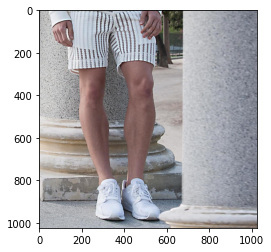

In [28]:
img = plt.imread(f'./train/{name}')
img
plt.imshow(img)


In [29]:
img.shape


(1024, 1024, 3)

In [42]:
len(polygon)

44

In [43]:
def new_format(coordinates):
  new_coordinates = []
  for x in range(0,len(coordinates),2):
    tempX = coordinates[x]
    tempY = coordinates[x+1] 
    temp = (tempX,tempY)
    new_coordinates.append(temp)
  return new_coordinates



In [44]:
new_format(polygon)

[(471, 390),
 (461, 412),
 (457, 430),
 (454, 455),
 (454, 473),
 (457, 483),
 (469, 489),
 (477, 492),
 (485, 498),
 (493, 499),
 (499, 496),
 (500, 490),
 (494, 479),
 (487, 461),
 (485, 445),
 (483, 434),
 (487, 433),
 (489, 426),
 (489, 412),
 (484, 403),
 (480, 395),
 (477, 392)]

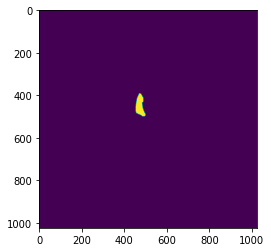

In [46]:
base_mask = Image.new('L',(1024,1024),0)
plt.imshow(base_mask)
ImageDraw.Draw(base_mask).polygon(polygon,outline=1,fill=1)
mask = np.array(base_mask)
plt.imshow(mask)

In [ ]:
TRAIN_PATH = './train'

In [ ]:
train_ids = next(os.walk(TRAIN_PATH))

In [ ]:
train_ids

('./train',
 [],
 ['ae4865c4af0a7e87dd5c6a7304fe57d3.jpg',
  '045e3f121065c013bf40146676f04756.jpg',
  'a7f34be335db522200eca65b5160a6a0.jpg',
  '59272e017a9ebc112f3e93b1ab153974.jpg',
  'a8e7d12b5efc2135d8cd8dfad3bf52cd.jpg',
  'eb8322ef97eff6e825e10eb6878d597d.jpg',
  '660fdd694e827b716de91918b0eaebeb.jpg',
  'ba5c114e89a39d4b335b096b490be881.jpg',
  '6c6d5463c7ff200d7ed41d3e3f9ccb8e.jpg',
  '1753a81cef6a973fde3d0a97f0c17ac0.jpg',
  'acfeaf3a440c0b95811f20368c11fbc8.jpg',
  'd5de5626bf6be1ad8fea7e5fcde2087a.jpg',
  'dae5dfbd041819c8d8e507f5ccc5daf8.jpg',
  'eed2a73a4dc7506b1ce5042c0d86a41f.jpg',
  '9c3ac0c179d368d84b2de16bb42216a4.jpg',
  'ad686bcbc15476eb8f4a1b1802cce006.jpg',
  '5de754136785169fa3fa6e677867eb34.jpg',
  'b79dc811bd81a5aece47a2d439d04937.jpg',
  'ee7a219a1af3dd000677d8a5bb8c650a.jpg',
  '8bfab8db7ff18a5cc4f41fac5e69194c.jpg',
  'c76b636c1021039bea6726bf2f00be85.jpg',
  '1a9b091d53b39344bf39b989f02fb56f.jpg',
  '3954a0c5661dcfd6c82df816fb020633.jpg',
  'e118794c612922

##Note preprocessing 

In [ ]:
IMAGE_WIDTH = 124
IMAGE_HEIGHT = 124
IMAGE_CHANNELS = 3

In [ ]:
X_train = np.zeros((len(train_ids), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)

NameError: ignored

In [ ]:
## resizing images
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMAGE_CHANNELS]  
    img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)
    

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K





def model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)   
  

    #Contraction 
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansion
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model.summary()
    
    return 

In [ ]:
model()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_8 (Lambda)              (None, 256, 256, 1)  0           ['input_12[0][0]']               
                                                                                                  
 conv2d_164 (Conv2D)            (None, 256, 256, 16  160         ['lambda_8[0][0]']               
                                )                                                                 
                                                                                            

In [ ]:
#checkpoint 
checkpointer = tf.keras.callbacks.ModelCheckpoint('image-segmentation_for_opendata',verbose=1,save_best_only=True )
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(logs_dir='./logs')
]
results = model.fit(X,Y,validation_split=0.1,batch_size=16,epochs=25,callbacks=callbacks)

SyntaxError: ignored